# Add many "Section discharge" result specifications

This example shows how to add multiple "Section discharge" result specifications for 2D overland models. Basic workflow is:

1. Import section coordinates.
2. Create result specification for each section.
3. Add result specifications to a particular simulation ID.

In [1]:
import mikeplus as mp
import geopandas as gpd
import contextily as cx

#### Setup a dummy database to work with

In [2]:
db = mp.create("my_model.sqlite")

# Enable 2D Overland
(
    db.tables.m_ModelSetting
    .update({
        db.tables.m_ModelSetting.columns.ModelNo : 1,
        db.tables.m_ModelSetting.columns.Enable_2DOverland : 1,
    })
    .by_muid("MuModel")
    .execute() 
)

['MuModel']

#### 1. Import section coordinates.

In [3]:
# Read sections from shapefile into GeoDataFrame
gdf = gpd.read_file("../tests/testdata/notebooks/sections.shp")
gdf

,id,name,geometry
0,NaN,Section A,"LINESTRING (718491.472 6197313.657, 718488.758..."
1,NaN,Section B,"LINESTRING (718414.203 6197320.587, 718457.219..."
2,NaN,Section C,"LINESTRING (718346.568 6197339.455, 718355.316..."


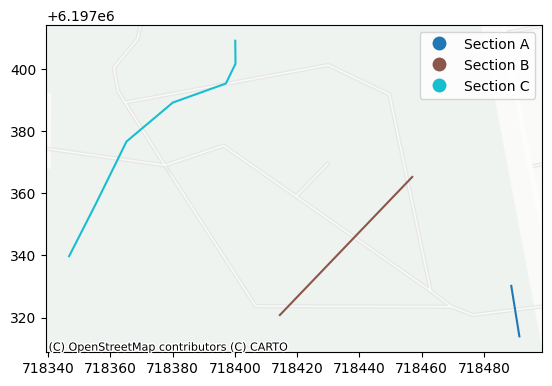

In [4]:
# Plot the sections
ax = gdf.plot(column="name", legend=True)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.Positron)

In [5]:
# Create a dictionary with keys as section names and values as a list of xy coordinates of the section
sections_xy = {}
for name in gdf["name"]:
    sections_xy[name] = list(gdf[gdf["name"] == name].geometry.values[0].coords)
print("Section A", sections_xy["Section A"])

Section A [(718491.4717670247, 6197313.657350091), (718488.7577802106, 6197330.542639723)]


#### 2. Create result specification for each section.

In [6]:
# Create one result specification per cross section with the appropriate types

for name in sections_xy:
    db.tables.msm_RS.insert({
        db.tables.msm_RS.columns.MUID: name,        # Numbers derived from MIKE+ GUI (by trial and error)
        db.tables.msm_RS.columns.ModelTypeNo: 3,    # 3 = 2D Overland
        db.tables.msm_RS.columns.ContentTypeNo: 21, # 21 = Section discharge
        db.tables.msm_RS.columns.FormatNo: 2        # 2 = Dfs0  

    })

In [7]:
db.tables.msm_RS.to_dataframe().tail()

,MUID,ModelTypeNo,ContentTypeNo,FormatNo,DefaultNo
Default_2D_Volume_balance,Default_2D_Volume_balance,3,20,2,1
Default_2D_MIKE_ECOLab,Default_2D_MIKE_ECOLab,3,61,4,1
Section A,Section A,3,21,2,0
Section B,Section B,3,21,2,0
Section C,Section C,3,21,2,0


In [8]:
db.tables.msm_RSS.to_dataframe().tail()

,MUID,ResultSpecID,SelectionNo,SubsetNo,IndividualNo,SelectionListID,ElementID,GridPointNo,Chainage,InterpolationTypeNo,...,TypeNo,DrawOnMap,FormatNo,FormatDelimiter,FormatColumnWidth,FormatDecimalNum,FormatMaxNo,FormatTimeMaxNo,FormatMinNo,FormatTimeMinNo
2D_Volume_balance,2D_Volume_balance,Default_2D_Volume_balance,1,1,1,None,None,1,0.0,1,...,None,drawonmap,None,None,None,None,None,None,None,None
2D_AREA_ECOLab,2D_AREA_ECOLab,Default_2D_MIKE_ECOLab,1,1,1,None,None,1,0.0,1,...,None,drawonmap,None,None,None,None,None,None,None,None
Sel_1,Sel_1,Section A,1,1,1,,,1,0.0,1,...,1,drawonmap,1,;,1,4,0,0,0,0
Sel_2,Sel_2,Section B,1,1,1,,,1,0.0,1,...,1,drawonmap,1,;,1,4,0,0,0,0
Sel_3,Sel_3,Section C,1,1,1,,,1,0.0,1,...,1,drawonmap,1,;,1,4,0,0,0,0


In [9]:
# Insert the secion coordinates into the database. Note that coordinates must be in the same projection as the model.
for name, xy in sections_xy.items():

    selection_id = (db.tables.msm_RSS
        .select(["MUID"])
        .where(f"{db.tables.msm_RSS.columns.ResultSpecID} == '{name}'")
        .execute().popitem()[0]
    )

    for i, (x, y) in enumerate(xy):
        db.tables.msm_RSSGeom.insert({
            db.tables.msm_RSSGeom.columns.X: x,
            db.tables.msm_RSSGeom.columns.Y: y,
            db.tables.msm_RSSGeom.columns.Sqn: i + 1,
            db.tables.msm_RSSGeom.columns.SelectionID: selection_id,
        })

In [10]:
# Confirm our insertions (optional)
db.tables.msm_RSSGeom.to_dataframe()

,MUID,SelectionID,Sqn,X,Y,ElemID
RSSG_1,RSSG_1,Sel_1,1,718491.471767,6197313.65735,None
RSSG_2,RSSG_2,Sel_1,2,718488.75778,6197330.54264,None
RSSG_3,RSSG_3,Sel_2,1,718414.20335,6197320.5868,None
RSSG_4,RSSG_4,Sel_2,2,718457.21868,6197365.469927,None
RSSG_5,RSSG_5,Sel_3,1,718346.567625,6197339.455258,None
RSSG_6,RSSG_6,Sel_3,2,718355.316217,6197356.609705,None
RSSG_7,RSSG_7,Sel_3,3,718365.161893,6197376.604945,None
RSSG_8,RSSG_8,Sel_3,4,718380.037582,6197389.116818,None
RSSG_9,RSSG_9,Sel_3,5,718397.096727,6197395.23965,None
RSSG_10,RSSG_10,Sel_3,6,718400.187884,6197401.585596,None


#### 3. Add result specifications to a particular simulation ID.

In [11]:
# Create a new 2D overland simulation
simulation_id = "my_simulation"

db.tables.msm_Project.insert({
    db.tables.msm_Project.columns.MUID: simulation_id,
    db.tables.msm_Project.columns.Enable_2DOverland: 1,
    db.tables.msm_Project.columns.Enable_HD: 1,
})

db.tables.msm_Project.to_dataframe()

,MUID,Sqn,IncludeToBatchNo,ScenarioName,EventID,ActiveProject,Enable_Catchment,Enable_CS,Enable_River,Enable_2DOverland,...,DecouplingPath,ELIntegrationNo,ELUpdateFrequency,M2DADDtMax,M2DADDtMin,M2DADMaxCFL,MJLFileName,HDOutputNo,HDFolderPath,SummaryID
my_simulation,my_simulation,1,None,Base,0,1,0,0,0,1,...,None,3,1,10.0,0.01,0.8,None,1,None,Summary_my_simulation


In [12]:
# Add all of the new result specifications to the simulation
for name in sections_xy:

    db.tables.msm_ProjectOutput.insert({
        db.tables.msm_ProjectOutput.columns.SimulationID: simulation_id,
        db.tables.msm_ProjectOutput.columns.OutputID: name,
        db.tables.msm_ProjectOutput.columns.ContentsTypeNo: 21, # 21 = Section discharge
        db.tables.msm_ProjectOutput.columns.FormatNo: 2 # 2 = Dfs0
    })

db.tables.msm_ProjectOutput.to_dataframe().tail()

,MUID,SimulationID,OutputID,ContentsTypeNo,FormatNo,DtSave,DtSaveUnitNo,DefaultSavePeriodNo,SaveStartDate,SaveEndDate
SimulationOutput_15,SimulationOutput_15,my_simulation,Default_2D_Volume_balance,20,2,60,1,1,2026-01-01 00:00:00,2026-01-01 02:00:00
SimulationOutput_16,SimulationOutput_16,my_simulation,Default_2D_MIKE_ECOLab,61,4,60,1,1,2026-01-01 00:00:00,2026-01-01 02:00:00
SimulationOutput_17,SimulationOutput_17,my_simulation,Section A,21,2,60,1,1,None,None
SimulationOutput_18,SimulationOutput_18,my_simulation,Section B,21,2,60,1,1,None,None
SimulationOutput_19,SimulationOutput_19,my_simulation,Section C,21,2,60,1,1,None,None


In [13]:
# Close the database
db.close()

#### Clean up

In [14]:
# Delete the temporary database
if db.db_path.exists():
    db.db_path.unlink()